# MuseGAN Training

## imports

In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import types
import pydot
from models.MuseGAN import MuseGAN
from utils.loaders import load_music


from music21 import midi
from music21 import note, stream, duration



Using TensorFlow backend.


In [3]:
# run params
SECTION = 'compose'
RUN_ID = '0018'
DATA_NAME = 'chorales'
FILENAME = 'Jsb16thSeparated.npz'
# DATA_NAME = 'npz'
# FILENAME = 'train_x_lpd_5_phr.npz'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])



if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))
    os.mkdir(os.path.join(RUN_FOLDER, 'samples'))

mode =  'build' # ' 'load' # 

## data

In [4]:
BATCH_SIZE = 64
n_bars = 16
n_steps_per_bar = 16
n_pitches = 84
n_tracks = 4

data_binary, data_ints, raw_data = load_music(DATA_NAME, FILENAME, n_bars, n_steps_per_bar)
data_binary = np.squeeze(data_binary)

## architecture

In [5]:
gan = MuseGAN(input_dim = data_binary.shape[1:]
        , critic_learning_rate = 0.001
        , generator_learning_rate = 0.001
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 32
        , batch_size = BATCH_SIZE
        , n_tracks = n_tracks
        , n_bars = n_bars
        , n_steps_per_bar = n_steps_per_bar
        , n_pitches = n_pitches
        )

if mode == 'build':
    gan.save(RUN_FOLDER)
else:                 
    gan.load_weights(RUN_FOLDER)

W1122 18:39:17.339564 139620787275584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1122 18:39:17.357273 139620787275584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1122 18:39:17.358134 139620787275584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W1122 18:39:17.513667 139620787275584 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1122 18:39:17.514324 139620787275

Tensor("loss/model_1_loss/Neg:0", shape=(), dtype=float32)
Tensor("loss/model_1_loss_1/Neg:0", shape=(), dtype=float32)
Tensor("loss_1/model_1_loss/Neg:0", shape=(), dtype=float32)


In [6]:
gan.chords_tempNetwork.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
temporal_input (InputLayer)  (None, 32)                0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 32)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 2, 1, 1024)        66560     
_________________________________________________________________
batch_normalization_1 (Batch (None, 2, 1, 1024)        4096      
_________________________________________________________________
activation_1 (Activation)    (None, 2, 1, 1024)        0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 1, 32)         491552    
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 1, 32)         128       
__________

In [7]:
gan.barGen[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bar_generator_input (InputLa (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              132096    
_________________________________________________________________
batch_normalization_11 (Batc (None, 1024)              4096      
_________________________________________________________________
activation_11 (Activation)   (None, 1024)              0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 2, 1, 512)         0         
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 4, 1, 512)         524800    
_________________________________________________________________
batch_normalization_12 (Batc (None, 4, 1, 512)         2048      
__________

In [8]:
gan.generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
melody_input (InputLayer)       (None, 4, 32)        0                                            
__________________________________________________________________________________________________
chords_input (InputLayer)       (None, 32)           0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 32)           0           melody_input[0][0]               
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 32)           0           melody_input[0][0]               
__________________________________________________________________________________________________
lambda_3 (

In [9]:
gan.critic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    (None, 16, 16, 84, 4)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 16, 84, 128)   1152      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 15, 16, 84, 128)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 1, 16, 84, 128)    245888    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1, 16, 84, 128)    0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 1, 16, 7, 128)     196736    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1, 16, 7, 128)     0         
__________

## training

In [10]:

EPOCHS = 3000
PRINT_EVERY_N_BATCHES = 5

gan.epoch = 0

In [11]:
gan.train(     
    data_binary
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
W1122 18:40:42.376734 139620787275584 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 (5, 1) [D loss: (-1.5)(R -10.8, F 0.0, G 0.9)] [G loss: 0.2]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 (5, 1) [D loss: (-1299.7)(R -1772.7, F 201.2, G 27.2)] [G loss: -105.3]
2 (5, 1) [D loss: (-1048.2)(R -1633.3, F 380.8, G 20.4)] [G loss: -599.1]
3 (5, 1) [D loss: (-1136.1)(R -2805.0, F 939.0, G 73.0)] [G loss: -950.8]
4 (5, 1) [D loss: (-769.8)(R -2346.4, F 1034.3, G 54.2)] [G loss: -1057.5]
5 (5, 1) [D loss: (-451.4)(R -1609.3, F 874.1, G 28.4)] [G loss: -805.4]
6 (5, 1) [D loss: (-203.6)(R -1227.5, F 818.5, G 20.5)] [G loss: -1020.2]
7 (5, 1) [D loss: (-74.3)(R -392.7, F 303.1, G 1.5)] [G loss: -275.8]
8 (5, 1) [D loss: (-36.0)(R -113.7, F 66.5, G 1.1)] [G loss: 170.6]
9 (5, 1) [D loss: (-41.4)(R 1010.7, F -1082.3, G 3.0)] [G loss: 887.1]
10 (5, 1) [D loss: (-27.8)(R 908.1, F -946.8, G 1.1)] [G loss: 978.6]
11 (5, 1) [D loss: (-21.6)(R 560.1, F -583.3, G 0.2)] [G loss: 841.0]
12 (5, 1) [D loss: (2.1)(R 103.4, F -104.2, G 0.3)] [G loss: 100.0]
13 (5, 1) [D loss: (-18.8)(R -252.4, F 229.2, G 0.4)] [G loss: -200.0]
14 (5, 1) [D loss: (-32.1)(R -96.5, F 58.8, G 0.6)] [G loss: 110.3]


117 (5, 1) [D loss: (-108.8)(R -451.7, F 283.4, G 5.9)] [G loss: -158.1]
118 (5, 1) [D loss: (-113.5)(R -467.6, F 320.3, G 3.4)] [G loss: -336.0]
119 (5, 1) [D loss: (-116.0)(R -440.3, F 280.0, G 4.4)] [G loss: -350.2]
120 (5, 1) [D loss: (-118.4)(R -583.0, F 400.8, G 6.4)] [G loss: -379.1]
121 (5, 1) [D loss: (-115.8)(R -532.1, F 345.0, G 7.1)] [G loss: -372.0]
122 (5, 1) [D loss: (-126.2)(R -607.8, F 416.3, G 6.5)] [G loss: -451.7]
123 (5, 1) [D loss: (-111.4)(R -482.1, F 326.4, G 4.4)] [G loss: -460.2]
124 (5, 1) [D loss: (-119.0)(R -766.4, F 580.6, G 6.7)] [G loss: -458.9]
125 (5, 1) [D loss: (-111.5)(R -716.7, F 526.7, G 7.8)] [G loss: -482.0]
126 (5, 1) [D loss: (-122.2)(R -617.9, F 435.1, G 6.1)] [G loss: -531.7]
127 (5, 1) [D loss: (-119.3)(R -417.7, F 239.2, G 5.9)] [G loss: -336.8]
128 (5, 1) [D loss: (-112.6)(R -387.3, F 242.0, G 3.3)] [G loss: -337.7]
129 (5, 1) [D loss: (-115.7)(R -250.3, F 96.8, G 3.8)] [G loss: -203.0]
130 (5, 1) [D loss: (-113.6)(R -463.5, F 294.4, G 5.

230 (5, 1) [D loss: (-121.9)(R -490.2, F 280.2, G 8.8)] [G loss: -255.5]
231 (5, 1) [D loss: (-109.6)(R -559.1, F 362.3, G 8.7)] [G loss: -272.9]
232 (5, 1) [D loss: (-115.2)(R -558.8, F 390.8, G 5.3)] [G loss: -417.5]
233 (5, 1) [D loss: (-117.2)(R -382.1, F 210.4, G 5.4)] [G loss: -242.2]
234 (5, 1) [D loss: (-108.5)(R -487.7, F 280.5, G 9.9)] [G loss: -188.1]
235 (5, 1) [D loss: (-114.7)(R -311.8, F 141.5, G 5.6)] [G loss: -213.1]
236 (5, 1) [D loss: (-106.4)(R -287.8, F 152.2, G 2.9)] [G loss: -154.1]
237 (5, 1) [D loss: (-116.8)(R -517.8, F 325.2, G 7.6)] [G loss: -253.4]
238 (5, 1) [D loss: (-119.5)(R -458.0, F 300.8, G 3.8)] [G loss: -264.1]
239 (5, 1) [D loss: (-116.6)(R -466.1, F 261.5, G 8.8)] [G loss: -250.2]
240 (5, 1) [D loss: (-117.4)(R -359.4, F 175.0, G 6.7)] [G loss: -128.9]
241 (5, 1) [D loss: (-117.7)(R -374.1, F 202.8, G 5.4)] [G loss: -243.9]
242 (5, 1) [D loss: (-117.3)(R -443.8, F 267.0, G 6.0)] [G loss: -345.1]
243 (5, 1) [D loss: (-115.5)(R -387.7, F 233.6, G 3

343 (5, 1) [D loss: (-118.6)(R -252.6, F 63.6, G 7.0)] [G loss: -44.2]
344 (5, 1) [D loss: (-109.8)(R -285.8, F 110.9, G 6.5)] [G loss: -81.5]
345 (5, 1) [D loss: (-117.3)(R -329.5, F 143.9, G 6.8)] [G loss: -161.7]
346 (5, 1) [D loss: (-111.8)(R -390.5, F 183.1, G 9.6)] [G loss: -84.6]
347 (5, 1) [D loss: (-113.0)(R -293.6, F 118.3, G 6.2)] [G loss: -136.6]
348 (5, 1) [D loss: (-118.2)(R -341.0, F 127.9, G 9.5)] [G loss: -81.8]
349 (5, 1) [D loss: (-117.4)(R -346.9, F 148.5, G 8.1)] [G loss: -126.1]
350 (5, 1) [D loss: (-118.6)(R -371.4, F 184.2, G 6.9)] [G loss: -190.4]
351 (5, 1) [D loss: (-118.0)(R -337.8, F 155.2, G 6.5)] [G loss: -149.1]
352 (5, 1) [D loss: (-112.3)(R -309.8, F 102.6, G 9.5)] [G loss: -86.9]
353 (5, 1) [D loss: (-122.2)(R -257.3, F 66.9, G 6.8)] [G loss: -76.1]
354 (5, 1) [D loss: (-116.0)(R -416.9, F 246.6, G 5.4)] [G loss: -301.1]
355 (5, 1) [D loss: (-119.1)(R -287.5, F 95.0, G 7.3)] [G loss: -89.0]
356 (5, 1) [D loss: (-111.0)(R -280.6, F 90.3, G 7.9)] [G los

457 (5, 1) [D loss: (-113.9)(R -223.3, F 71.9, G 3.8)] [G loss: -121.3]
458 (5, 1) [D loss: (-117.6)(R -329.0, F 128.7, G 8.3)] [G loss: -109.7]
459 (5, 1) [D loss: (-118.7)(R -237.9, F 51.8, G 6.7)] [G loss: -13.0]
460 (5, 1) [D loss: (-119.4)(R -366.5, F 158.8, G 8.8)] [G loss: -106.8]
461 (5, 1) [D loss: (-118.6)(R -268.5, F 83.2, G 6.7)] [G loss: -90.9]
462 (5, 1) [D loss: (-117.2)(R -276.1, F 102.0, G 5.7)] [G loss: -127.3]
463 (5, 1) [D loss: (-115.8)(R -278.4, F 74.7, G 8.8)] [G loss: -47.1]
464 (5, 1) [D loss: (-117.1)(R -241.7, F 62.4, G 6.2)] [G loss: -88.7]
465 (5, 1) [D loss: (-116.5)(R -213.1, F 57.0, G 4.0)] [G loss: -89.8]
466 (5, 1) [D loss: (-113.5)(R -280.2, F 89.3, G 7.7)] [G loss: -56.9]
467 (5, 1) [D loss: (-116.6)(R -265.9, F 90.4, G 5.9)] [G loss: -64.7]
468 (5, 1) [D loss: (-118.6)(R -374.3, F 184.0, G 7.2)] [G loss: -149.8]
469 (5, 1) [D loss: (-131.0)(R -340.1, F 154.0, G 5.5)] [G loss: -140.4]
470 (5, 1) [D loss: (-110.5)(R -205.7, F 39.4, G 5.6)] [G loss: -4

572 (5, 1) [D loss: (-119.3)(R -280.1, F 98.3, G 6.3)] [G loss: -121.8]
573 (5, 1) [D loss: (-116.5)(R -214.7, F 33.9, G 6.4)] [G loss: -1.9]
574 (5, 1) [D loss: (-119.7)(R -233.8, F 63.0, G 5.1)] [G loss: -77.9]
575 (5, 1) [D loss: (-117.8)(R -292.4, F 107.8, G 6.7)] [G loss: -107.9]
576 (5, 1) [D loss: (-106.6)(R -320.5, F 115.5, G 9.8)] [G loss: -81.3]
577 (5, 1) [D loss: (-111.1)(R -240.6, F 75.0, G 5.4)] [G loss: -93.4]
578 (5, 1) [D loss: (-113.5)(R -271.6, F 75.3, G 8.3)] [G loss: -67.7]
579 (5, 1) [D loss: (-115.0)(R -231.5, F 28.3, G 8.8)] [G loss: -51.2]
580 (5, 1) [D loss: (-117.3)(R -257.1, F 64.8, G 7.5)] [G loss: -23.3]
581 (5, 1) [D loss: (-110.9)(R -277.6, F 87.4, G 7.9)] [G loss: -66.7]
582 (5, 1) [D loss: (-120.3)(R -316.2, F 116.3, G 8.0)] [G loss: -96.8]
583 (5, 1) [D loss: (-119.4)(R -287.7, F 106.0, G 6.2)] [G loss: -112.9]
584 (5, 1) [D loss: (-113.9)(R -260.7, F 85.1, G 6.2)] [G loss: -61.5]
585 (5, 1) [D loss: (-115.4)(R -243.6, F 56.8, G 7.1)] [G loss: -45.0]


687 (5, 1) [D loss: (-114.6)(R -322.9, F 111.9, G 9.6)] [G loss: -81.8]
688 (5, 1) [D loss: (-119.4)(R -225.8, F 39.1, G 6.7)] [G loss: -11.3]
689 (5, 1) [D loss: (-119.5)(R -266.6, F 90.2, G 5.7)] [G loss: -77.2]
690 (5, 1) [D loss: (-117.6)(R -233.7, F 62.9, G 5.3)] [G loss: -63.1]
691 (5, 1) [D loss: (-120.2)(R -276.0, F 98.7, G 5.7)] [G loss: -69.8]
692 (5, 1) [D loss: (-117.2)(R -202.3, F 42.1, G 4.3)] [G loss: -60.3]
693 (5, 1) [D loss: (-116.2)(R -223.5, F 50.6, G 5.7)] [G loss: -33.3]
694 (5, 1) [D loss: (-117.7)(R -228.5, F 34.4, G 7.6)] [G loss: -50.0]
695 (5, 1) [D loss: (-113.5)(R -208.0, F 9.5, G 8.5)] [G loss: -51.5]
696 (5, 1) [D loss: (-117.7)(R -244.3, F 49.6, G 7.7)] [G loss: -46.1]
697 (5, 1) [D loss: (-114.0)(R -194.3, F 46.2, G 3.4)] [G loss: -108.0]
698 (5, 1) [D loss: (-120.1)(R -268.7, F 82.5, G 6.6)] [G loss: -73.7]
699 (5, 1) [D loss: (-114.4)(R -253.8, F 62.7, G 7.7)] [G loss: -53.1]
700 (5, 1) [D loss: (-118.2)(R -234.4, F 75.1, G 4.1)] [G loss: -84.8]
701 (

802 (5, 1) [D loss: (-64.6)(R -556.3, F 355.8, G 13.6)] [G loss: -338.6]
803 (5, 1) [D loss: (-114.8)(R -250.9, F 87.9, G 4.8)] [G loss: -105.1]
804 (5, 1) [D loss: (-116.0)(R -265.9, F 100.9, G 4.9)] [G loss: -103.5]
805 (5, 1) [D loss: (-121.8)(R -321.9, F 115.1, G 8.5)] [G loss: -115.7]
806 (5, 1) [D loss: (-118.9)(R -264.3, F 81.4, G 6.4)] [G loss: -79.4]
807 (5, 1) [D loss: (-122.0)(R -288.0, F 94.3, G 7.2)] [G loss: -105.9]
808 (5, 1) [D loss: (-122.6)(R -269.4, F 90.0, G 5.7)] [G loss: -79.2]
809 (5, 1) [D loss: (-118.7)(R -260.9, F 76.8, G 6.5)] [G loss: -69.4]
810 (5, 1) [D loss: (-120.5)(R -292.0, F 98.5, G 7.3)] [G loss: -89.2]
811 (5, 1) [D loss: (-115.6)(R -290.2, F 92.4, G 8.2)] [G loss: -87.6]
812 (5, 1) [D loss: (-119.0)(R -279.5, F 84.2, G 7.6)] [G loss: -94.8]
813 (5, 1) [D loss: (-116.7)(R -248.0, F 62.8, G 6.9)] [G loss: -63.0]
814 (5, 1) [D loss: (-119.3)(R -289.3, F 102.0, G 6.8)] [G loss: -110.2]
815 (5, 1) [D loss: (-118.6)(R -244.7, F 68.0, G 5.8)] [G loss: -67

917 (5, 1) [D loss: (-121.3)(R -250.6, F 64.5, G 6.5)] [G loss: -59.7]
918 (5, 1) [D loss: (-117.8)(R -230.1, F 60.3, G 5.2)] [G loss: -42.6]
919 (5, 1) [D loss: (-117.8)(R -246.1, F 47.6, G 8.1)] [G loss: -35.1]
920 (5, 1) [D loss: (-114.1)(R -246.0, F 45.4, G 8.7)] [G loss: -37.4]
921 (5, 1) [D loss: (-119.8)(R -235.0, F 43.4, G 7.2)] [G loss: -30.6]
922 (5, 1) [D loss: (-119.2)(R -211.3, F 28.2, G 6.4)] [G loss: -43.6]
923 (5, 1) [D loss: (-118.9)(R -246.6, F 53.5, G 7.4)] [G loss: -24.7]
924 (5, 1) [D loss: (-118.4)(R -269.0, F 65.1, G 8.5)] [G loss: -40.9]
925 (5, 1) [D loss: (-115.0)(R -264.0, F 100.6, G 4.8)] [G loss: -86.8]
926 (5, 1) [D loss: (-107.3)(R -160.0, F -4.8, G 5.8)] [G loss: -95.7]
927 (5, 1) [D loss: (-124.5)(R -294.8, F 86.1, G 8.4)] [G loss: -40.2]
928 (5, 1) [D loss: (-116.7)(R -243.7, F 57.0, G 7.0)] [G loss: -54.5]
929 (5, 1) [D loss: (-112.4)(R -266.6, F 53.7, G 10.0)] [G loss: -47.8]
930 (5, 1) [D loss: (-121.8)(R -216.8, F 26.1, G 6.9)] [G loss: -77.7]
931 

1032 (5, 1) [D loss: (-118.4)(R -266.0, F 70.1, G 7.8)] [G loss: -46.1]
1033 (5, 1) [D loss: (-122.7)(R -247.8, F 36.4, G 8.9)] [G loss: -41.9]
1034 (5, 1) [D loss: (-120.2)(R -235.8, F 35.0, G 8.1)] [G loss: -51.8]
1035 (5, 1) [D loss: (-122.0)(R -258.5, F 63.7, G 7.3)] [G loss: -54.1]
1036 (5, 1) [D loss: (-122.8)(R -240.9, F 46.8, G 7.1)] [G loss: -49.9]
1037 (5, 1) [D loss: (-119.5)(R -224.0, F 38.9, G 6.6)] [G loss: -30.1]
1038 (5, 1) [D loss: (-119.6)(R -257.0, F 39.1, G 9.8)] [G loss: -49.3]
1039 (5, 1) [D loss: (-121.6)(R -285.9, F 83.1, G 8.1)] [G loss: -34.5]
1040 (5, 1) [D loss: (-118.9)(R -261.7, F 63.8, G 7.9)] [G loss: -47.6]
1041 (5, 1) [D loss: (-119.2)(R -260.2, F 56.0, G 8.5)] [G loss: -36.0]
1042 (5, 1) [D loss: (-120.3)(R -266.9, F 66.6, G 8.0)] [G loss: -67.5]
1043 (5, 1) [D loss: (-97.2)(R -201.1, F 22.1, G 8.2)] [G loss: -74.1]
1044 (5, 1) [D loss: (-122.2)(R -269.0, F 74.2, G 7.3)] [G loss: -60.6]
1045 (5, 1) [D loss: (-120.8)(R -227.3, F 63.4, G 4.3)] [G loss: 

1146 (5, 1) [D loss: (-122.2)(R -271.6, F 65.4, G 8.4)] [G loss: -57.7]
1147 (5, 1) [D loss: (-126.1)(R -305.5, F 92.9, G 8.7)] [G loss: -24.4]
1148 (5, 1) [D loss: (-121.2)(R -289.4, F 59.2, G 10.9)] [G loss: -47.7]
1149 (5, 1) [D loss: (-136.1)(R -258.1, F 58.3, G 6.4)] [G loss: -82.9]
1150 (5, 1) [D loss: (-126.4)(R -473.2, F 268.2, G 7.9)] [G loss: -137.5]
1151 (5, 1) [D loss: (-122.2)(R -278.2, F 94.6, G 6.1)] [G loss: -107.7]
1152 (5, 1) [D loss: (-126.4)(R -271.3, F 78.2, G 6.7)] [G loss: -88.8]
1153 (5, 1) [D loss: (-121.2)(R -245.7, F 58.6, G 6.6)] [G loss: -50.0]
1154 (5, 1) [D loss: (-123.4)(R -285.5, F 113.2, G 4.9)] [G loss: -96.6]
1155 (5, 1) [D loss: (-123.1)(R -279.8, F 63.4, G 9.3)] [G loss: -37.8]
1156 (5, 1) [D loss: (-85.9)(R -210.8, F 0.7, G 12.4)] [G loss: -152.3]
1157 (5, 1) [D loss: (-123.9)(R -321.1, F 118.8, G 7.8)] [G loss: -72.7]
1158 (5, 1) [D loss: (-123.1)(R -285.1, F 67.0, G 9.5)] [G loss: -42.7]
1159 (5, 1) [D loss: (-125.2)(R -274.2, F 68.8, G 8.0)] [G

1260 (5, 1) [D loss: (-124.6)(R -257.8, F 51.3, G 8.2)] [G loss: -58.2]
1261 (5, 1) [D loss: (-124.7)(R -216.6, F 36.5, G 5.5)] [G loss: -45.3]
1262 (5, 1) [D loss: (-130.7)(R -211.3, F 26.8, G 5.4)] [G loss: -76.4]
1263 (5, 1) [D loss: (-125.7)(R -213.6, F 36.4, G 5.1)] [G loss: -53.7]
1264 (5, 1) [D loss: (-126.4)(R -259.8, F 52.1, G 8.1)] [G loss: -19.0]
1265 (5, 1) [D loss: (-125.2)(R -251.2, F 42.0, G 8.4)] [G loss: -29.5]
1266 (5, 1) [D loss: (-132.0)(R -278.5, F 48.2, G 9.8)] [G loss: -31.1]
1267 (5, 1) [D loss: (-127.6)(R -258.4, F 67.9, G 6.3)] [G loss: -54.7]
1268 (5, 1) [D loss: (-123.4)(R -226.3, F 45.4, G 5.7)] [G loss: -24.7]
1269 (5, 1) [D loss: (-111.4)(R -169.9, F 16.7, G 4.2)] [G loss: -72.5]
1270 (5, 1) [D loss: (-105.6)(R -201.2, F 75.5, G 2.0)] [G loss: -145.7]
1271 (5, 1) [D loss: (-118.3)(R -251.6, F 15.6, G 11.8)] [G loss: -40.7]
1272 (5, 1) [D loss: (-126.1)(R -214.4, F 43.4, G 4.5)] [G loss: -46.9]
1273 (5, 1) [D loss: (-126.5)(R -255.1, F 51.4, G 7.7)] [G los

1374 (5, 1) [D loss: (-133.7)(R -230.2, F 37.7, G 5.9)] [G loss: -56.6]
1375 (5, 1) [D loss: (-133.4)(R -263.2, F 42.2, G 8.8)] [G loss: -39.6]
1376 (5, 1) [D loss: (-129.1)(R -230.9, F 38.7, G 6.3)] [G loss: -34.6]
1377 (5, 1) [D loss: (-131.6)(R -246.0, F 46.7, G 6.8)] [G loss: -28.8]
1378 (5, 1) [D loss: (-124.5)(R -275.5, F 41.8, G 10.9)] [G loss: -17.4]
1379 (5, 1) [D loss: (-134.3)(R -226.3, F 26.5, G 6.5)] [G loss: -35.7]
1380 (5, 1) [D loss: (-125.3)(R -226.9, F 27.5, G 7.4)] [G loss: -33.8]
1381 (5, 1) [D loss: (-127.3)(R -248.7, F 40.4, G 8.1)] [G loss: -22.7]
1382 (5, 1) [D loss: (-128.2)(R -185.8, F 9.7, G 4.8)] [G loss: -50.0]
1383 (5, 1) [D loss: (-123.9)(R -234.6, F 30.8, G 8.0)] [G loss: -17.8]
1384 (5, 1) [D loss: (-123.5)(R -237.7, F 52.4, G 6.2)] [G loss: -24.3]
1385 (5, 1) [D loss: (-127.2)(R -227.4, F 35.2, G 6.5)] [G loss: -39.7]
1386 (5, 1) [D loss: (-128.4)(R -254.4, F 53.1, G 7.3)] [G loss: -37.8]
1387 (5, 1) [D loss: (-129.8)(R -244.5, F 36.1, G 7.9)] [G loss:

1488 (5, 1) [D loss: (-130.2)(R -213.0, F 24.2, G 5.9)] [G loss: -53.5]
1489 (5, 1) [D loss: (-128.9)(R -205.0, F 19.6, G 5.7)] [G loss: -23.5]
1490 (5, 1) [D loss: (-136.6)(R -246.6, F 27.1, G 8.3)] [G loss: -23.7]
1491 (5, 1) [D loss: (-129.9)(R -229.3, F 14.4, G 8.5)] [G loss: -36.3]
1492 (5, 1) [D loss: (-128.0)(R -223.4, F 18.2, G 7.7)] [G loss: -24.3]
1493 (5, 1) [D loss: (-131.6)(R -241.1, F 25.5, G 8.4)] [G loss: 11.6]
1494 (5, 1) [D loss: (-124.7)(R -210.2, F 32.3, G 5.3)] [G loss: -25.0]
1495 (5, 1) [D loss: (-131.0)(R -220.0, F 29.5, G 5.9)] [G loss: -42.2]
1496 (5, 1) [D loss: (-127.6)(R -255.0, F 34.0, G 9.3)] [G loss: -41.9]
1497 (5, 1) [D loss: (-128.1)(R -196.0, F 12.9, G 5.5)] [G loss: -29.2]
1498 (5, 1) [D loss: (-127.2)(R -185.1, F 7.3, G 5.1)] [G loss: -40.8]
1499 (5, 1) [D loss: (-133.6)(R -246.8, F 24.0, G 8.9)] [G loss: -24.9]
1500 (5, 1) [D loss: (-129.8)(R -210.6, F 9.3, G 7.2)] [G loss: -31.3]
1501 (5, 1) [D loss: (-128.5)(R -254.8, F 36.2, G 9.0)] [G loss: -3

1602 (5, 1) [D loss: (-135.5)(R -228.7, F 28.1, G 6.5)] [G loss: -22.7]
1603 (5, 1) [D loss: (-130.4)(R -240.9, F 30.9, G 8.0)] [G loss: -14.5]
1604 (5, 1) [D loss: (-131.0)(R -241.2, F 26.0, G 8.4)] [G loss: -18.1]
1605 (5, 1) [D loss: (-127.6)(R -217.8, F 21.7, G 6.8)] [G loss: -16.5]
1606 (5, 1) [D loss: (-128.2)(R -212.5, F 22.3, G 6.2)] [G loss: -38.0]
1607 (5, 1) [D loss: (-128.3)(R -221.7, F 20.9, G 7.2)] [G loss: -7.4]
1608 (5, 1) [D loss: (-133.1)(R -270.3, F 47.7, G 8.9)] [G loss: -49.9]
1609 (5, 1) [D loss: (-131.4)(R -222.6, F 14.1, G 7.7)] [G loss: -25.4]
1610 (5, 1) [D loss: (-130.9)(R -257.7, F 32.2, G 9.5)] [G loss: -25.7]
1611 (5, 1) [D loss: (-130.7)(R -248.8, F 27.6, G 9.0)] [G loss: -9.5]
1612 (5, 1) [D loss: (-133.5)(R -240.2, F 27.5, G 7.9)] [G loss: -28.0]
1613 (5, 1) [D loss: (-131.5)(R -220.0, F 33.9, G 5.5)] [G loss: -27.5]
1614 (5, 1) [D loss: (-130.5)(R -216.0, F 17.9, G 6.8)] [G loss: -34.2]
1615 (5, 1) [D loss: (-126.9)(R -203.4, F 12.3, G 6.4)] [G loss: -

1717 (5, 1) [D loss: (-129.0)(R -278.1, F 45.5, G 10.4)] [G loss: -16.2]
1718 (5, 1) [D loss: (-134.0)(R -223.2, F 19.5, G 7.0)] [G loss: -30.5]
1719 (5, 1) [D loss: (-133.4)(R -227.7, F 19.8, G 7.4)] [G loss: -25.2]
1720 (5, 1) [D loss: (-135.0)(R -223.2, F 20.4, G 6.8)] [G loss: -15.5]
1721 (5, 1) [D loss: (-132.6)(R -271.6, F 48.9, G 9.0)] [G loss: -32.4]
1722 (5, 1) [D loss: (-130.7)(R -221.2, F 14.4, G 7.6)] [G loss: -13.5]
1723 (5, 1) [D loss: (-137.9)(R -263.6, F 32.6, G 9.3)] [G loss: -21.9]
1724 (5, 1) [D loss: (-133.0)(R -201.4, F 14.2, G 5.4)] [G loss: -21.5]
1725 (5, 1) [D loss: (-130.3)(R -238.8, F 30.2, G 7.8)] [G loss: -15.3]
1726 (5, 1) [D loss: (-130.5)(R -234.0, F 29.4, G 7.4)] [G loss: -29.5]
1727 (5, 1) [D loss: (-129.8)(R -221.7, F 16.5, G 7.5)] [G loss: -21.1]
1728 (5, 1) [D loss: (-131.3)(R -270.9, F 33.9, G 10.6)] [G loss: -25.1]
1729 (5, 1) [D loss: (-134.2)(R -252.8, F 41.0, G 7.8)] [G loss: -34.2]
1730 (5, 1) [D loss: (-130.9)(R -197.6, F 9.1, G 5.8)] [G loss

1832 (5, 1) [D loss: (-132.7)(R -246.9, F 25.7, G 8.9)] [G loss: -13.8]
1833 (5, 1) [D loss: (-131.5)(R -206.4, F 4.9, G 7.0)] [G loss: -33.6]
1834 (5, 1) [D loss: (-132.1)(R -236.8, F 17.9, G 8.7)] [G loss: -6.4]
1835 (5, 1) [D loss: (-131.5)(R -239.8, F 8.1, G 10.0)] [G loss: -22.1]
1836 (5, 1) [D loss: (-134.7)(R -207.0, F 12.3, G 6.0)] [G loss: -48.3]
1837 (5, 1) [D loss: (-135.2)(R -199.1, F 0.2, G 6.4)] [G loss: 3.6]
1838 (5, 1) [D loss: (-134.2)(R -229.0, F 11.3, G 8.3)] [G loss: -6.1]
1839 (5, 1) [D loss: (-133.9)(R -242.1, F 22.8, G 8.5)] [G loss: -3.9]
1840 (5, 1) [D loss: (-133.5)(R -232.8, F 21.8, G 7.7)] [G loss: -23.6]
1841 (5, 1) [D loss: (-132.3)(R -224.1, F 24.8, G 6.7)] [G loss: -22.8]
1842 (5, 1) [D loss: (-136.0)(R -234.6, F 22.8, G 7.6)] [G loss: -20.4]
1843 (5, 1) [D loss: (-134.5)(R -223.2, F 22.0, G 6.7)] [G loss: -24.1]
1844 (5, 1) [D loss: (-133.2)(R -213.0, F 17.9, G 6.2)] [G loss: -23.3]
1845 (5, 1) [D loss: (-136.7)(R -245.9, F 28.9, G 8.0)] [G loss: -15.8]

1947 (5, 1) [D loss: (-134.3)(R -233.1, F 13.0, G 8.6)] [G loss: -19.3]
1948 (5, 1) [D loss: (-130.9)(R -228.5, F 15.9, G 8.2)] [G loss: -4.9]
1949 (5, 1) [D loss: (-135.8)(R -240.0, F 28.2, G 7.6)] [G loss: -20.5]
1950 (5, 1) [D loss: (-132.1)(R -230.8, F 18.9, G 8.0)] [G loss: -19.1]
1951 (5, 1) [D loss: (-132.5)(R -220.6, F 22.4, G 6.6)] [G loss: -14.8]
1952 (5, 1) [D loss: (-133.9)(R -228.8, F 20.7, G 7.4)] [G loss: -18.2]
1953 (5, 1) [D loss: (-131.5)(R -236.2, F 24.9, G 8.0)] [G loss: -6.9]
1954 (5, 1) [D loss: (-133.7)(R -252.7, F 29.5, G 9.0)] [G loss: -8.7]
1955 (5, 1) [D loss: (-136.2)(R -270.1, F 32.9, G 10.1)] [G loss: -16.6]
1956 (5, 1) [D loss: (-131.2)(R -267.9, F 25.3, G 11.1)] [G loss: -12.5]
1957 (5, 1) [D loss: (-133.0)(R -250.9, F 24.3, G 9.4)] [G loss: -10.0]
1958 (5, 1) [D loss: (-131.4)(R -254.1, F 25.8, G 9.7)] [G loss: -30.8]
1959 (5, 1) [D loss: (-135.3)(R -229.3, F 20.4, G 7.4)] [G loss: -16.8]
1960 (5, 1) [D loss: (-134.8)(R -220.6, F 11.7, G 7.4)] [G loss: 

2062 (5, 1) [D loss: (-129.2)(R -172.3, F -12.4, G 5.6)] [G loss: -22.2]
2063 (5, 1) [D loss: (-137.2)(R -229.8, F 17.2, G 7.5)] [G loss: -10.4]
2064 (5, 1) [D loss: (-134.5)(R -206.8, F 11.9, G 6.0)] [G loss: -16.4]
2065 (5, 1) [D loss: (-139.9)(R -237.1, F 22.4, G 7.5)] [G loss: -15.9]
2066 (5, 1) [D loss: (-137.6)(R -251.5, F 18.1, G 9.6)] [G loss: -31.7]
2067 (5, 1) [D loss: (-132.7)(R -189.9, F 3.1, G 5.4)] [G loss: -31.3]
2068 (5, 1) [D loss: (-137.3)(R -233.6, F 12.3, G 8.4)] [G loss: -6.0]
2069 (5, 1) [D loss: (-132.9)(R -273.5, F 28.7, G 11.2)] [G loss: -8.3]
2070 (5, 1) [D loss: (-134.9)(R -226.3, F 13.1, G 7.8)] [G loss: -14.8]
2071 (5, 1) [D loss: (-136.2)(R -217.7, F 11.5, G 7.0)] [G loss: -17.7]
2072 (5, 1) [D loss: (-133.5)(R -204.8, F 5.3, G 6.6)] [G loss: -16.7]
2073 (5, 1) [D loss: (-133.3)(R -211.5, F 12.2, G 6.6)] [G loss: -22.4]
2074 (5, 1) [D loss: (-133.3)(R -272.8, F 30.7, G 10.9)] [G loss: -11.2]
2075 (5, 1) [D loss: (-134.7)(R -199.2, F -1.3, G 6.6)] [G loss: 

2176 (5, 1) [D loss: (-135.6)(R -232.6, F 18.3, G 7.9)] [G loss: -17.2]
2177 (5, 1) [D loss: (-134.6)(R -220.0, F 11.1, G 7.4)] [G loss: -18.3]
2178 (5, 1) [D loss: (-134.8)(R -223.7, F 11.0, G 7.8)] [G loss: -17.7]
2179 (5, 1) [D loss: (-136.0)(R -232.2, F 13.9, G 8.2)] [G loss: -19.3]
2180 (5, 1) [D loss: (-131.4)(R -252.4, F 17.1, G 10.4)] [G loss: -20.9]
2181 (5, 1) [D loss: (-134.8)(R -249.3, F 18.7, G 9.6)] [G loss: -13.1]
2182 (5, 1) [D loss: (-133.0)(R -239.0, F 16.5, G 8.9)] [G loss: -11.3]
2183 (5, 1) [D loss: (-135.2)(R -239.1, F 15.9, G 8.8)] [G loss: -17.6]
2184 (5, 1) [D loss: (-138.2)(R -249.6, F 15.7, G 9.6)] [G loss: -17.5]
2185 (5, 1) [D loss: (-133.1)(R -258.4, F 18.0, G 10.7)] [G loss: -22.3]
2186 (5, 1) [D loss: (-135.6)(R -238.6, F 15.9, G 8.7)] [G loss: -15.6]
2187 (5, 1) [D loss: (-136.8)(R -238.1, F 20.8, G 8.1)] [G loss: -21.6]
2188 (5, 1) [D loss: (-132.0)(R -218.8, F 15.7, G 7.1)] [G loss: -15.9]
2189 (5, 1) [D loss: (-131.4)(R -274.1, F 21.2, G 12.1)] [G lo

2290 (5, 1) [D loss: (-138.3)(R -214.1, F 12.5, G 6.3)] [G loss: -15.3]
2291 (5, 1) [D loss: (-133.0)(R -233.9, F 13.9, G 8.7)] [G loss: -10.3]
2292 (5, 1) [D loss: (-137.8)(R -240.4, F 24.7, G 7.8)] [G loss: -15.4]
2293 (5, 1) [D loss: (-138.1)(R -234.0, F 17.4, G 7.9)] [G loss: -21.6]
2294 (5, 1) [D loss: (-135.2)(R -228.3, F 16.2, G 7.7)] [G loss: -15.4]
2295 (5, 1) [D loss: (-139.4)(R -222.8, F 14.3, G 6.9)] [G loss: -17.6]
2296 (5, 1) [D loss: (-137.9)(R -215.4, F 5.3, G 7.2)] [G loss: -33.9]
2297 (5, 1) [D loss: (-135.5)(R -237.9, F 36.4, G 6.6)] [G loss: -21.5]
2298 (5, 1) [D loss: (-134.0)(R -251.7, F 22.4, G 9.5)] [G loss: -14.4]
2299 (5, 1) [D loss: (-139.0)(R -227.4, F 15.8, G 7.3)] [G loss: -22.7]
2300 (5, 1) [D loss: (-134.8)(R -226.8, F 11.4, G 8.1)] [G loss: -14.9]
2301 (5, 1) [D loss: (-138.5)(R -214.7, F 11.5, G 6.5)] [G loss: -11.6]
2302 (5, 1) [D loss: (-136.2)(R -235.6, F 16.7, G 8.3)] [G loss: -15.1]
2303 (5, 1) [D loss: (-136.0)(R -221.9, F 16.0, G 7.0)] [G loss: 

2405 (5, 1) [D loss: (-135.5)(R -240.3, F 15.0, G 9.0)] [G loss: -14.6]
2406 (5, 1) [D loss: (-137.6)(R -226.5, F 12.3, G 7.7)] [G loss: -13.8]
2407 (5, 1) [D loss: (-136.9)(R -228.8, F 17.5, G 7.4)] [G loss: -11.2]
2408 (5, 1) [D loss: (-135.8)(R -221.8, F 14.3, G 7.2)] [G loss: -16.3]
2409 (5, 1) [D loss: (-135.7)(R -196.2, F 4.7, G 5.6)] [G loss: -24.4]
2410 (5, 1) [D loss: (-138.3)(R -234.8, F 11.7, G 8.5)] [G loss: -9.6]
2411 (5, 1) [D loss: (-133.4)(R -241.2, F 14.6, G 9.3)] [G loss: -8.9]
2412 (5, 1) [D loss: (-136.8)(R -238.9, F 25.1, G 7.7)] [G loss: -18.7]
2413 (5, 1) [D loss: (-136.8)(R -230.2, F 14.4, G 7.9)] [G loss: -16.0]
2414 (5, 1) [D loss: (-136.1)(R -228.6, F 13.8, G 7.9)] [G loss: -14.5]
2415 (5, 1) [D loss: (-138.1)(R -222.4, F 13.2, G 7.1)] [G loss: -14.1]
2416 (5, 1) [D loss: (-134.9)(R -247.1, F 14.9, G 9.7)] [G loss: -21.2]
2417 (5, 1) [D loss: (-134.7)(R -225.9, F 22.8, G 6.8)] [G loss: -10.1]
2418 (5, 1) [D loss: (-135.7)(R -218.8, F 19.3, G 6.4)] [G loss: -2

2520 (5, 1) [D loss: (-136.2)(R -233.9, F 14.9, G 8.3)] [G loss: -14.8]
2521 (5, 1) [D loss: (-135.6)(R -234.9, F 18.6, G 8.1)] [G loss: -11.6]
2522 (5, 1) [D loss: (-135.6)(R -228.4, F 15.6, G 7.7)] [G loss: -14.0]
2523 (5, 1) [D loss: (-138.2)(R -217.7, F 15.7, G 6.4)] [G loss: -17.6]
2524 (5, 1) [D loss: (-139.2)(R -227.4, F 11.0, G 7.7)] [G loss: -11.1]
2525 (5, 1) [D loss: (-136.2)(R -260.1, F 31.0, G 9.3)] [G loss: -16.2]
2526 (5, 1) [D loss: (-132.8)(R -248.2, F 18.4, G 9.7)] [G loss: -14.2]
2527 (5, 1) [D loss: (-139.7)(R -226.3, F 9.9, G 7.7)] [G loss: -17.3]
2528 (5, 1) [D loss: (-135.8)(R -231.2, F 15.4, G 8.0)] [G loss: -14.9]
2529 (5, 1) [D loss: (-137.0)(R -245.4, F 12.4, G 9.6)] [G loss: -10.0]
2530 (5, 1) [D loss: (-136.4)(R -218.5, F 12.9, G 6.9)] [G loss: -15.4]
2531 (5, 1) [D loss: (-136.4)(R -230.1, F 27.5, G 6.6)] [G loss: -30.3]
2532 (5, 1) [D loss: (-130.4)(R -270.8, F 50.3, G 9.0)] [G loss: -17.8]
2533 (5, 1) [D loss: (-138.2)(R -230.9, F 11.8, G 8.1)] [G loss: 

2635 (5, 1) [D loss: (-137.3)(R -249.4, F 23.0, G 8.9)] [G loss: -9.2]
2636 (5, 1) [D loss: (-139.5)(R -245.6, F 13.3, G 9.3)] [G loss: -14.6]
2637 (5, 1) [D loss: (-136.3)(R -211.9, F 7.7, G 6.8)] [G loss: -19.4]
2638 (5, 1) [D loss: (-137.0)(R -231.0, F 11.0, G 8.3)] [G loss: -9.0]
2639 (5, 1) [D loss: (-136.9)(R -246.0, F 14.1, G 9.5)] [G loss: -11.4]
2640 (5, 1) [D loss: (-136.7)(R -250.1, F 18.3, G 9.5)] [G loss: -13.4]
2641 (5, 1) [D loss: (-139.8)(R -261.5, F 23.4, G 9.8)] [G loss: -15.2]
2642 (5, 1) [D loss: (-137.6)(R -221.1, F 17.1, G 6.6)] [G loss: -14.1]
2643 (5, 1) [D loss: (-135.7)(R -248.5, F 18.7, G 9.4)] [G loss: -12.0]
2644 (5, 1) [D loss: (-139.5)(R -237.0, F 17.6, G 8.0)] [G loss: -8.2]
2645 (5, 1) [D loss: (-136.9)(R -256.6, F 21.3, G 9.8)] [G loss: -12.2]
2646 (5, 1) [D loss: (-135.5)(R -221.2, F 13.6, G 7.2)] [G loss: -23.0]
2647 (5, 1) [D loss: (-136.9)(R -207.8, F 5.2, G 6.6)] [G loss: -17.8]
2648 (5, 1) [D loss: (-140.1)(R -226.4, F 8.6, G 7.8)] [G loss: -12.1

2750 (5, 1) [D loss: (-140.0)(R -230.4, F 17.0, G 7.3)] [G loss: -11.5]
2751 (5, 1) [D loss: (-137.5)(R -223.0, F 12.3, G 7.3)] [G loss: -14.1]
2752 (5, 1) [D loss: (-128.9)(R -275.8, F 18.6, G 12.8)] [G loss: -9.8]
2753 (5, 1) [D loss: (-137.4)(R -251.5, F 17.1, G 9.7)] [G loss: -8.4]
2754 (5, 1) [D loss: (-138.3)(R -230.4, F 17.2, G 7.5)] [G loss: -14.0]
2755 (5, 1) [D loss: (-138.0)(R -233.1, F 16.6, G 7.9)] [G loss: -10.4]
2756 (5, 1) [D loss: (-138.8)(R -246.2, F 15.2, G 9.2)] [G loss: -15.3]
2757 (5, 1) [D loss: (-134.9)(R -229.2, F 12.2, G 8.2)] [G loss: -12.7]
2758 (5, 1) [D loss: (-136.1)(R -240.2, F 15.8, G 8.8)] [G loss: -14.1]
2759 (5, 1) [D loss: (-138.8)(R -252.1, F 16.1, G 9.7)] [G loss: -16.0]
2760 (5, 1) [D loss: (-136.3)(R -224.2, F 11.1, G 7.7)] [G loss: -15.3]
2761 (5, 1) [D loss: (-134.4)(R -206.2, F 14.1, G 5.8)] [G loss: -15.4]
2762 (5, 1) [D loss: (-139.1)(R -217.9, F 10.3, G 6.8)] [G loss: -14.2]
2763 (5, 1) [D loss: (-136.6)(R -228.1, F 14.6, G 7.7)] [G loss: 

2865 (5, 1) [D loss: (-138.5)(R -233.4, F 14.0, G 8.1)] [G loss: -9.9]
2866 (5, 1) [D loss: (-137.3)(R -205.4, F 6.9, G 6.1)] [G loss: -14.5]
2867 (5, 1) [D loss: (-136.5)(R -226.0, F 13.0, G 7.7)] [G loss: -16.6]
2868 (5, 1) [D loss: (-137.1)(R -218.4, F 11.3, G 7.0)] [G loss: -16.3]
2869 (5, 1) [D loss: (-141.4)(R -236.0, F 14.9, G 8.0)] [G loss: -11.6]
2870 (5, 1) [D loss: (-136.3)(R -232.2, F 15.3, G 8.1)] [G loss: -2.9]
2871 (5, 1) [D loss: (-138.1)(R -250.5, F 16.3, G 9.6)] [G loss: -12.1]
2872 (5, 1) [D loss: (-137.8)(R -236.1, F 10.9, G 8.7)] [G loss: -14.5]
2873 (5, 1) [D loss: (-140.8)(R -223.9, F 7.7, G 7.5)] [G loss: -38.2]
2874 (5, 1) [D loss: (-137.1)(R -239.9, F 16.9, G 8.6)] [G loss: -5.6]
2875 (5, 1) [D loss: (-139.8)(R -245.5, F 13.2, G 9.2)] [G loss: -14.4]
2876 (5, 1) [D loss: (-139.5)(R -230.0, F 12.6, G 7.8)] [G loss: -16.7]
2877 (5, 1) [D loss: (-138.8)(R -233.2, F 13.9, G 8.0)] [G loss: -15.5]
2878 (5, 1) [D loss: (-138.8)(R -233.2, F 10.4, G 8.4)] [G loss: -12.

2980 (5, 1) [D loss: (-136.7)(R -228.5, F 11.0, G 8.1)] [G loss: -11.0]
2981 (5, 1) [D loss: (-135.9)(R -217.6, F 14.4, G 6.7)] [G loss: -14.8]
2982 (5, 1) [D loss: (-137.4)(R -228.8, F 7.4, G 8.4)] [G loss: -18.6]
2983 (5, 1) [D loss: (-137.9)(R -237.5, F 11.7, G 8.8)] [G loss: -8.7]
2984 (5, 1) [D loss: (-134.9)(R -216.2, F 9.1, G 7.2)] [G loss: -8.0]
2985 (5, 1) [D loss: (-140.2)(R -235.7, F 14.4, G 8.1)] [G loss: -15.4]
2986 (5, 1) [D loss: (-139.4)(R -237.2, F 14.1, G 8.4)] [G loss: -17.0]
2987 (5, 1) [D loss: (-139.1)(R -215.1, F 9.8, G 6.6)] [G loss: -12.2]
2988 (5, 1) [D loss: (-137.1)(R -234.1, F 11.2, G 8.6)] [G loss: -17.3]
2989 (5, 1) [D loss: (-137.5)(R -220.0, F 10.4, G 7.2)] [G loss: -13.4]
2990 (5, 1) [D loss: (-137.0)(R -254.2, F 17.4, G 10.0)] [G loss: -10.3]
2991 (5, 1) [D loss: (-139.1)(R -249.2, F 14.8, G 9.5)] [G loss: -12.8]
2992 (5, 1) [D loss: (-141.4)(R -224.3, F 17.6, G 6.5)] [G loss: -18.3]
2993 (5, 1) [D loss: (-136.7)(R -255.9, F 19.7, G 10.0)] [G loss: -5

#######

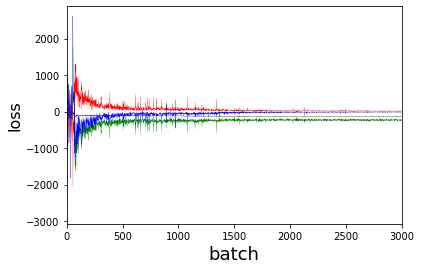

In [12]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25)
plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25)
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25)
plt.plot(gan.g_losses, color='blue', linewidth=0.25)

plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)

plt.xlim(0, len(gan.d_losses))
# plt.ylim(0, 2)

plt.show()
